In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models
from tqdm import tqdm
from torch.utils.data import random_split

# Data Downloading and Extracting

In [2]:
# !pip install kaggle --upgrade
# !kaggle competitions download -c 2019-characters-classification

In [3]:
# import zipfile 

# def unzip(zip_filename: str, dst_dir: str = './'):
#     with zipfile.ZipFile(zip_filename, 'r') as zf:
#         for entry in tqdm(zf.infolist(), desc = 'Extracting '):
#             try:
#                 zf.extract(entry, dst_dir)
#             except zipfile.error as e:
#                 print(e)
#                 pass

# unzip('2019-characters-classification.zip')

In [4]:
# unzip('test.npy.zip')

In [5]:
# unzip('train-1.npy.zip')
# unzip('train-2.npy.zip')
# unzip('train-3.npy.zip')
# unzip('train-4.npy.zip')

# Data Loading and Preprocessing

In [6]:
test = np.load('test.npy', allow_pickle = True)
print(test[:2])
print(test.shape)
print(test[0].shape)
print(test[1].shape)

[array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
 array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)]
(83247,)
(96, 90)
(99, 75)


In [7]:
train_1 = np.load('train-1.npy', allow_pickle = True)
train_2 = np.load('train-2.npy', allow_pickle = True)
train_3 = np.load('train-3.npy', allow_pickle = True)
train_4 = np.load('train-4.npy', allow_pickle = True)
print(len(train_1), len(train_2), len(train_3), len(train_4))

83246 83247 83247 83247


In [8]:
train = np.concatenate((train_1, train_2, train_3, train_4))
print(train[:2])
print(len(train))

[[array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
  59076]
 [array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
  59076]]
332987


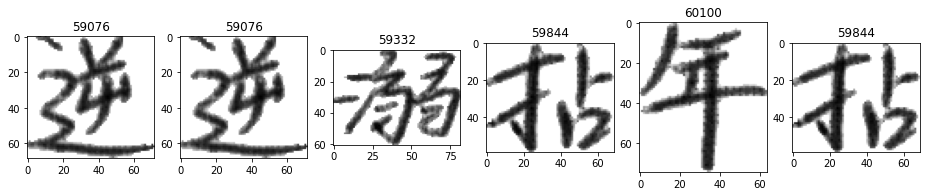

In [14]:
data = train[:6]
width, height = 6, 1

plt.figure(figsize=(16, 20))
for n, (image, tag) in enumerate(data, 1):
    if n > width * height:
        break
    plt.subplot(height, width, n)
    plt.title(tag)
    plt.imshow(image, cmap='gray')

# Data Preparation and Transforming

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [26]:
classes = np.sort(list(set(train[:, 1])))
print(classes[[0, -1]], len(classes))

[58827 65238] 1000


In [27]:
pd.Series(list(train[:, 1])).value_counts()

62925    400
64447    390
62163    383
60362    381
61641    378
        ... 
62134    288
59859    283
64959    282
63679    281
59831    279
Length: 1000, dtype: int64

In [28]:
class HieroglyphsDataset(Dataset):
    def __init__(self, data, transform = None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if len(self.data[idx]) == 2:
            sample = {'image': self.data[idx][0], 'category': np.searchsorted(classes, self.data[idx][1])}
        else:
            sample = {'image': self.data[idx]}

        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [29]:
class Transform(object):
    def __call__(self, sample):
        image, category = sample['image'], sample.get('category')
        t = torch.from_numpy(image).view(-1,image.shape[0],image.shape[1]).type(torch.FloatTensor)
        t = transforms.ToPILImage()(torch.cat((t, t, t),0))
        t = transforms.Resize((224, 224))(t)
        t = transforms.ToTensor()(t)
        t = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])(t)
        if category is None:
            return {'image': t.to(device)}
        else:
            return {'image': t.to(device),
                    'category': torch.from_numpy(np.array(category)).type(torch.LongTensor).to(device)} 

In [30]:
train_dataset = HieroglyphsDataset(data = train, transform = Transform())
test_dataset = HieroglyphsDataset(data = test, transform = Transform())

In [31]:
train_data, test_data = random_split(train_dataset, [int(len(train_dataset) * 0.7) + 1, int(len(train_dataset) * 0.3)])

trainloader = DataLoader(train_data, batch_size = 64, shuffle = True)
testloader = DataLoader(test_data, batch_size = 64, shuffle = True)

In [32]:
trainiter = iter(trainloader)
batch = next(trainiter)
print(batch['image'].size(), batch['category'].size())

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [33]:
test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle = True)

testiter = iter(test_dataloader)
batch = next(testiter)
print(batch['image'].size())

torch.Size([64, 3, 224, 224])


# Models Construction

In [34]:
# model that were used to obtain best score is actually lost
# here's some sample model

In [35]:
net = models.vgg16().to(device)
name = 'vgg16'
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Models Training and Evaluation

In [36]:
def Train(model, train_loader, optimizer):
    model.train()
    
    processed = 0
    total = len(train_loader.dataset)
    
    for batch_idx, sample_batched in enumerate(train_loader):
        X, y = sample_batched['image'], sample_batched['category']
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        probs = net(X)
        loss = criterion(probs, y)
        if not batch_idx % 10:
            print(f'{processed}/{total}, loss: {loss.item()}')
            
        loss.backward()
        optimizer.step()      
        
        processed += len(X)

In [37]:
def Test(model, test_loader):
    with torch.no_grad():
        model.eval()
        processed = 0
        total = len(test_loader.dataset)
        sum = 0
        for batch_idx, sample_batched in enumerate(test_loader):
            X, y = sample_batched['image'], sample_batched['category']
            X, y = X.to(device), y.to(device)
            probs = net(X)
            print(probs.size())
            s = np.sum(np.array([int(probs[i].argmax().item() == y[i].item()) for i in range(len(probs))]))
            processed += len(X)
            sum += s
            if not batch_idx % 100:
                print(sum/processed)
        print(sum, '/', total, sum/total)

In [15]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.01)

epochs_num = 5

for epoch in range(1, epochs_num):
    print(f'Epoch {epoch}:')
    Train(net, trainloader, optimizer)
    torch.save(net, f'{name}{epoch}epochs')
    Test(net, testloader)

Epoch 3:
0/116522, loss: 0.5163497924804688
640/116522, loss: 0.4995899796485901
1280/116522, loss: 0.4122880697250366
1920/116522, loss: 0.2210594117641449
2560/116522, loss: 0.2873203456401825
3200/116522, loss: 0.6210335493087769
3840/116522, loss: 0.37010371685028076
4480/116522, loss: 0.25982046127319336
5120/116522, loss: 0.3203766644001007
5760/116522, loss: 0.4485197365283966
6400/116522, loss: 0.5420888066291809
7040/116522, loss: 0.2786552309989929
7680/116522, loss: 0.46071481704711914
8320/116522, loss: 0.2772943079471588
8960/116522, loss: 0.35225710272789
9600/116522, loss: 0.2994958162307739
10240/116522, loss: 0.5052920579910278
10880/116522, loss: 0.3354016840457916
11520/116522, loss: 0.3998247981071472
12160/116522, loss: 0.19705317914485931
12800/116522, loss: 0.4498958885669708
13440/116522, loss: 0.49807173013687134
14080/116522, loss: 0.3650754690170288
14720/116522, loss: 0.34903472661972046
15360/116522, loss: 0.10012169182300568
16000/116522, loss: 0.230484664

13440/116522, loss: 0.15445563197135925
14080/116522, loss: 0.3494598865509033
14720/116522, loss: 0.1041504442691803
15360/116522, loss: 0.5790320634841919
16000/116522, loss: 0.1462101936340332
16640/116522, loss: 0.32962411642074585
17280/116522, loss: 0.11906042695045471
17920/116522, loss: 0.14401285350322723
18560/116522, loss: 0.19484874606132507
19200/116522, loss: 0.32206282019615173
19840/116522, loss: 0.09650209546089172
20480/116522, loss: 0.5602681040763855
21120/116522, loss: 0.36013200879096985
21760/116522, loss: 0.3405401110649109
22400/116522, loss: 0.33443182706832886
23040/116522, loss: 0.1596911996603012
23680/116522, loss: 0.3159656524658203
24320/116522, loss: 0.10855336487293243
24960/116522, loss: 0.17280186712741852
25600/116522, loss: 0.33247384428977966
26240/116522, loss: 0.16275827586650848
26880/116522, loss: 0.1568305343389511
27520/116522, loss: 0.3557543158531189
28160/116522, loss: 0.12893284857273102
28800/116522, loss: 0.3341549336910248
29440/11652

KeyboardInterrupt: 

In [16]:
Test(net, testloader)

0.921875
0.9439975247524752
0.9467506218905473
0.9470514950166113
0.9471243765586035
0.9475424151696606
0.9477173460898503
0.9470622325249644
47278 / 49938 0.9467339500981217


In [17]:
torch.save(net, f'{name}4epochs')

# Submission Making

In [32]:
dataloader = test_dataloader
print(len(dataloader), len(dataloader.dataset))
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched.size())
    if i_batch == 3:
        break

1301 83247
0 torch.Size([64, 3, 224, 224])
1 torch.Size([64, 3, 224, 224])
2 torch.Size([64, 3, 224, 224])
3 torch.Size([64, 3, 224, 224])


In [79]:
def Pred(model, test_loader):
    preds = []
    with torch.no_grad():
        model.eval()
        processed = 0
        total = len(test_loader)
        sum = 0
        for batch_idx, sample_batched in enumerate(test_loader):
            if not batch_idx % 100:
                print(batch_idx, total)
            X = sample_batched.to(device)
            probs = net(X)
           # print(classes[np.array([int(probs[i].argmax().item()) for i in range(len(probs))])])
            arr = classes[np.array([int(probs[i].argmax().item()) for i in range(len(probs))])]
            preds = np.append(preds, arr)
           # print(preds)
    with open('preds.csv', 'w') as out:
        print('Id,Category', file=out)
        for i,c in enumerate(preds):
            print(i+1,',',c,sep='',file=out)

In [ ]:
Pred(net, dataloader)

0 1301
